# BGG review score prediction: deep learning approach (YH)

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/clean_data.csv')
df = df[['comment', 'rating']].drop_duplicates()
df.shape

(97885, 2)

In [3]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
df_eng = df[df['comment'].apply(isEnglish)]
df_eng.shape

(92261, 2)

In [4]:
X = df_eng['comment']
y = df_eng['rating']

In [5]:
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 

def clean (text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word, pos = 'n') for word in words_only] # Lemmatize
    lemmatized1 = [lemma.lemmatize(word, pos = 'v') for word in lemmatized] # Lemmatize
    lemmatized2 = [lemma.lemmatize(word, pos = 'a') for word in lemmatized1] # Lemmatize
    lemmatized3 = [lemma.lemmatize(word, pos = 'r') for word in lemmatized2] # Lemmatize
    stop_words = ['it', 'and', 'an', 'a', 'my', 'this', 'that', 'to', 'be', 'is', 'i', 'you'] # Make stopword list
    without_stopwords = [word for word in lemmatized3 if not word in stop_words] 
    back_into_string = ' '.join(without_stopwords)
    return back_into_string

# Apply to all texts
clean_X = X.apply(clean)
clean_X

0                                     play once didnt like
1        several thing dislike player elimination which...
2        seem like ok game but doesnt really work for o...
3           flux munchkin mix but bad way way way too long
4        the game open the player sieged by group ease ...
                               ...                        
99994    at heart scrabble variant like more than scrab...
99995    get little more familiar with realize make gam...
99996    fun fast clever game feel like tricktaking gam...
99998    nice one first off buy play solitaire but the ...
99999    kid rat daughter enjoy one lot improvement ove...
Name: comment, Length: 92261, dtype: object

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.2)

## Tensorflow embeddings

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

### Let's tokenize the vocabulary 
tk = Tokenizer()
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index)
X_train_token = tk.texts_to_sequences(X_train)
X_test_token = tk.texts_to_sequences(X_test)

2022-09-16 15:19:01.409881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 15:19:01.562665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 15:19:01.562693: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-16 15:19:01.596395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-16 15:19:02.280566: W tensorflow/stream_executor/platform/de

30.004281378712335


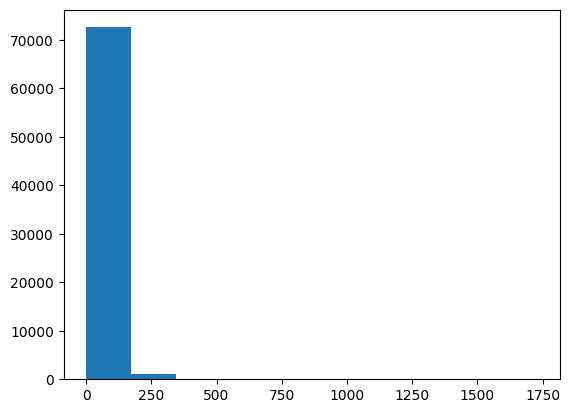

In [8]:
import matplotlib.pyplot as plt
lengths = [len(each) for each in X_train_token]
print(pd.Series(lengths).mean())
plt.hist(lengths);

In [9]:
vocab_size = len(tk.word_index)

print(f'There are {vocab_size} different words in the train set')

There are 42992 different words in the train set


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen = 100)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen = 100)

In [11]:
from tensorflow.keras import Sequential, layers

embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model.add(layers.LSTM(20))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

2022-09-16 15:19:06.832493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-16 15:19:06.832542: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 15:19:06.832559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (YH-PC): /proc/driver/nvidia/version does not exist
2022-09-16 15:19:06.832775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=16,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
3230/3230 [==============================] - 325s 100ms/step - loss: 5.3373 - mse: 5.3373 - mae: 1.8604 - val_loss: 3.7474 - val_mse: 3.7474 - val_mae: 1.5267
Epoch 2/20
3230/3230 [==============================] - 336s 104ms/step - loss: 3.4083 - mse: 3.4083 - mae: 1.4363 - val_loss: 3.6950 - val_mse: 3.6950 - val_mae: 1.5070
Epoch 3/20
3230/3230 [==============================] - 321s 99ms/step - loss: 3.0674 - mse: 3.0674 - mae: 1.3494 - val_loss: 3.2659 - val_mse: 3.2659 - val_mae: 1.4184
Epoch 4/20
3230/3230 [==============================] - 315s 98ms/step - loss: 2.8608 - mse: 2.8608 - mae: 1.2929 - val_loss: 3.2341 - val_mse: 3.2341 - val_mae: 1.3952
Epoch 5/20
3230/3230 [==============================] - 589s 182ms/step - loss: 2.6911 - mse: 2.6911 - mae: 1.2443 - val_loss: 3.2069 - val_mse: 3.2069 - val_mae: 1.3954
Epoch 6/20
3230/3230 [==============================] - 331s 102ms/step - loss: 2.5359 - mse: 2.5359 - mae: 1.1971 - val_loss: 3.2450 - val_mse: 3.2450 

## Model evaluation

In [14]:
y_preds = model.predict(X_test_pad)
y_preds

577/577 [==============================] - 8s 12ms/step


array([[3.0154233],
       [7.8441772],
       [5.6258125],
       ...,
       [4.878806 ],
       [7.456971 ],
       [6.1511197]], dtype=float32)

In [16]:
from sklearn.metrics import mean_absolute_error

score = mean_absolute_error(y_test, y_preds)
score

1.3755398313120466

In [19]:
y_pred_rounded = pd.Series(y_preds.flatten()).round(0)
y_pred_rounded

0        3.0
1        8.0
2        6.0
3        7.0
4        3.0
        ... 
18448    8.0
18449    5.0
18450    5.0
18451    7.0
18452    6.0
Length: 18453, dtype: float32

In [20]:
from sklearn.metrics import accuracy_score

model_accuracy = accuracy_score(y_test, y_pred_rounded)
model_accuracy

0.25567658375331925

In [62]:
model_accuracy2

0.591827887064434

In [60]:
labels1 = ['Bad','Average','High']
y_test_binned = pd.qcut(y_test,q=3, labels=labels1)
y_pred_rounded_binned = pd.qcut(y_pred_rounded,q=3, labels=labels1)
model_accuracy2 = accuracy_score(y_test_binned, y_pred_rounded_binned)
model_accuracy2
model.save('../raw_data/model.h5')

## Classifier

In [37]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
from tensorflow.keras import Sequential, layers

embedding_dimension = 50

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model2.add(layers.LSTM(20))
model2.add(layers.Dense(15, activation="relu"))
model2.add(layers.Dense(11, activation="softmax"))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

es = EarlyStopping(patience=2, restore_best_weights=True)

model2.fit(X_train_pad, y_train_cat, 
          epochs=20, 
          batch_size=16,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
3230/3230 [==============================] - 290s 89ms/step - loss: 1.9800 - accuracy: 0.2945 - val_loss: 1.8727 - val_accuracy: 0.3080
Epoch 2/20
3230/3230 [==============================] - 326s 101ms/step - loss: 1.8099 - accuracy: 0.3266 - val_loss: 1.8295 - val_accuracy: 0.3217
Epoch 3/20
3230/3230 [==============================] - 337s 104ms/step - loss: 1.7523 - accuracy: 0.3427 - val_loss: 1.8180 - val_accuracy: 0.3268
Epoch 4/20
3230/3230 [==============================] - 322s 100ms/step - loss: 1.7133 - accuracy: 0.3595 - val_loss: 1.8256 - val_accuracy: 0.3249
Epoch 5/20
3230/3230 [==============================] - 321s 99ms/step - loss: 1.6750 - accuracy: 0.3732 - val_loss: 1.8041 - val_accuracy: 0.3279
Epoch 6/20
3230/3230 [==============================] - 312s 97ms/step - loss: 1.6372 - accuracy: 0.3883 - val_loss: 1.8254 - val_accuracy: 0.3244
Epoch 7/20
3230/3230 [==============================] - 309s 96ms/step - loss: 1.5939 - accuracy: 0.4072 - val_loss

In [40]:
model2_preds = model2.predict(X_test_pad)
model2_preds


577/577 [==============================] - 8s 13ms/step


array([[3.3977796e-10, 2.0613944e-02, 7.0490152e-02, ..., 2.6278682e-02,
        6.2563233e-03, 2.4565833e-03],
       [3.5301612e-12, 2.4080928e-04, 1.1237544e-03, ..., 4.4912580e-01,
        1.9430898e-01, 8.8630997e-02],
       [1.0420402e-09, 2.8093020e-02, 7.1281984e-02, ..., 9.2547074e-02,
        3.4784399e-02, 2.1675581e-02],
       ...,
       [2.8731391e-09, 2.5767669e-02, 4.9757168e-02, ..., 1.6918863e-01,
        7.1697414e-02, 4.7364350e-02],
       [9.0198569e-09, 6.4923801e-03, 1.0956968e-02, ..., 3.2941696e-01,
        1.8331778e-01, 1.2472490e-01],
       [3.6968888e-08, 1.8223375e-02, 2.5406731e-02, ..., 2.6748222e-01,
        1.2298410e-01, 6.9926657e-02]], dtype=float32)

In [41]:
model2.save('../raw_data/model2.h5')

In [57]:
from tensorflow.keras import Sequential, layers
labels2 = [1,2,3]
y_train_binned = pd.qcut(y_train,q=3, labels=labels2)
# y_train_binned_cat = to_categorical(y_train_binned)
embedding_dimension = 50

model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model3.add(layers.LSTM(20))
model3.add(layers.Dense(15, activation="relu"))
model3.add(layers.Dense(4, activation="sigmoid"))

model3.compile(loss='SparseCategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])

es = EarlyStopping(patience=2, restore_best_weights=True)

model3.fit(X_train_pad, y_train_binned, 
          epochs=20, 
          batch_size=16,
          validation_split=0.3,
          callbacks=[es]
         )



Epoch 1/20
3230/3230 [==============================] - 280s 85ms/step - loss: 0.8602 - accuracy: 0.6006 - val_loss: 0.8275 - val_accuracy: 0.6194
Epoch 2/20
3230/3230 [==============================] - 304s 94ms/step - loss: 0.7713 - accuracy: 0.6509 - val_loss: 0.8006 - val_accuracy: 0.6388
Epoch 3/20
3230/3230 [==============================] - 303s 94ms/step - loss: 0.7402 - accuracy: 0.6709 - val_loss: 0.7815 - val_accuracy: 0.6437
Epoch 4/20
3230/3230 [==============================] - 309s 96ms/step - loss: 0.7146 - accuracy: 0.6846 - val_loss: 0.7909 - val_accuracy: 0.6360
Epoch 5/20
3230/3230 [==============================] - 307s 95ms/step - loss: 0.6898 - accuracy: 0.6990 - val_loss: 0.7854 - val_accuracy: 0.6528


In [58]:
model3.save('../raw_data/model3.h5')

In [59]:
model3_preds = model3.predict(X_test_pad)
model3_preds

577/577 [==============================] - 8s 13ms/step


array([[3.4150976e-16, 8.2750642e-01, 3.0659485e-01, 3.0216413e-02],
       [1.5994943e-13, 5.2078027e-02, 5.3366977e-01, 8.1599665e-01],
       [8.9454959e-16, 6.6510177e-01, 2.5375715e-01, 1.7677014e-01],
       ...,
       [2.7640601e-15, 5.5437726e-01, 3.8523343e-01, 2.9076800e-01],
       [1.9705215e-09, 1.7197174e-01, 4.9798504e-01, 6.6817057e-01],
       [1.6893027e-06, 3.9716384e-01, 5.0798142e-01, 5.2715892e-01]],
      dtype=float32)